<a href="https://colab.research.google.com/github/ANUSHKA-creator-web/ML_Battery_DDM/blob/main/Battery_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimal number of features: 2
Selected features: ['Capacity dV CCCT', 'Energy dV CCCT']
Stacking Regressor RMSE: 0.0005
Stacking Regressor R2 score: 0.9195


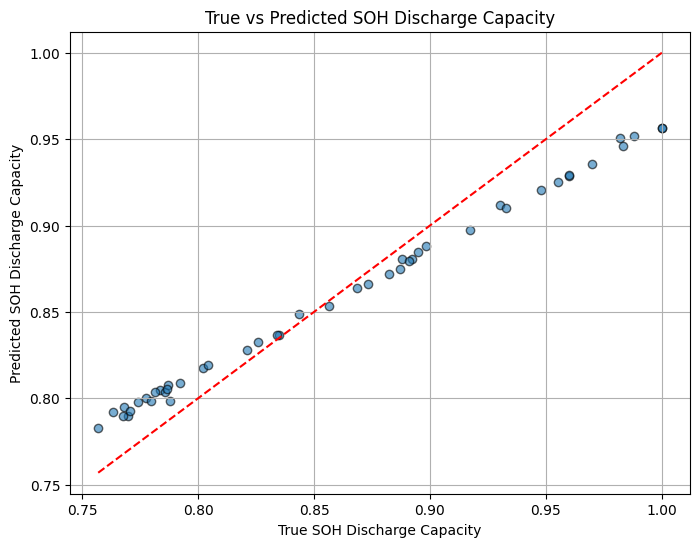

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, BayesianRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv('/content/drive/MyDrive/ML_dataset/dataset_training.csv')

# 2. Prepare Features and Target
feature_drop = ['Unnamed: 0', 'SOH_discharge_capacity', 'Group']  # Drop undesired columns
X = df.drop(columns=feature_drop)
y = df['SOH_discharge_capacity']

# Optional: Use GroupKFold if 'Group' signifies grouping factor to avoid data leakage
groups = df['Group']

# 3. Feature Selection
rf_selector = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
cv = GroupKFold(n_splits=len(np.unique(groups)))
rfecv = RFECV(estimator=rf_selector, step=1, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
rfecv.fit(X, y, groups=groups)

# Selected features mask and names
selected_features_mask = rfecv.support_
selected_features = X.columns[selected_features_mask]

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Selected features: {list(selected_features)}")

# Reduce X to selected features
X_selected = X[selected_features]

# 4. Train/Test Split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X_selected, y, groups, test_size=0.2, random_state=42, stratify=groups)

# 5. Define base models with pipelines (scaling inside)
pipe_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=5))])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor(n_estimators=200, random_state=42))])
pipe_gb = Pipeline([('scaler', StandardScaler()), ('gb', GradientBoostingRegressor(n_estimators=100, random_state=42))])
pipe_svr = Pipeline([('scaler', StandardScaler()), ('svr', SVR(C=1.0, kernel='rbf'))])

estimators = [
    ('knn', pipe_knn),
    ('rf', pipe_rf),
    ('gb', pipe_gb),
    ('svr', pipe_svr)
]

# Meta-model
meta_model = Ridge(alpha=1.0)

# 6. Stacking Regressor
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=meta_model, cv=5, n_jobs=-1)
stacking_reg.fit(X_train, y_train)

# 7. Predictions and Evaluation
y_pred = stacking_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Stacking Regressor RMSE: {rmse:.4f}")
print(f"Stacking Regressor R2 score: {r2:.4f}")

# 8. Plot true vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True SOH Discharge Capacity')
plt.ylabel('Predicted SOH Discharge Capacity')
plt.title('True vs Predicted SOH Discharge Capacity')
plt.grid(True)
plt.show()

Merged shape: (185721, 11)
Columns: Index(['cycle', 'ambient_temperature', 'datetime', 'capacity',
       'voltage_measured', 'current_measured', 'temperature_measured',
       'current_load', 'voltage_load', 'time', 'source_file'],
      dtype='object')
Optimal number of features: 7
Selected features: ['cycle', 'voltage_measured', 'current_measured', 'temperature_measured', 'current_load', 'voltage_load', 'time']
KNN -> RMSE: 0.0099, R2: 0.9973
RandomForest -> RMSE: 0.0058, R2: 0.9991
GradientBoosting -> RMSE: 0.0189, R2: 0.9902
SVR -> RMSE: 0.0458, R2: 0.9424
Ridge -> RMSE: 0.0670, R2: 0.8766


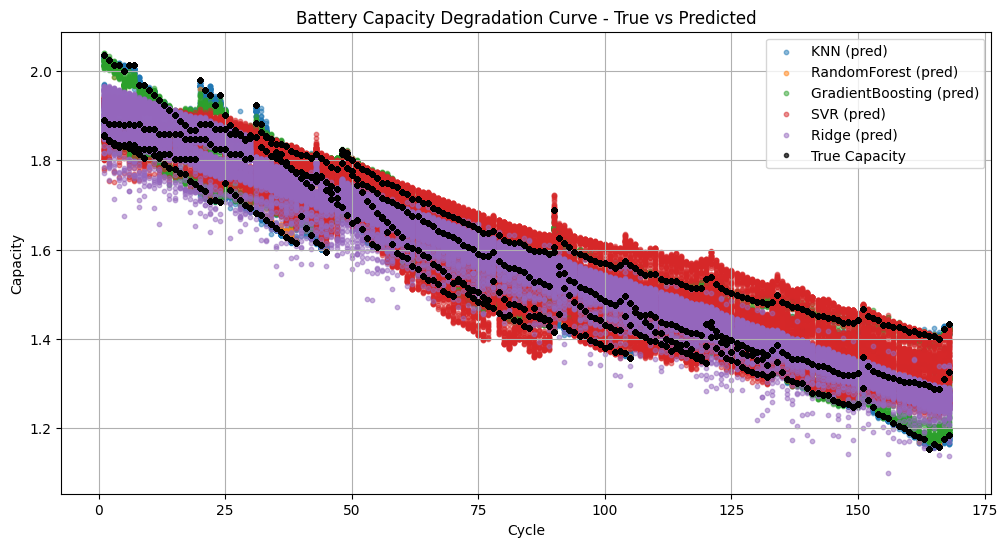

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# -------------------------------
# 1. Load the 4 CSVs
# -------------------------------
files = [
    r"B0005.csv",
    r"B0006.csv",
    r"B0007.csv",
    r"B0018.csv"
]

dfs = []
for file in files:
    df = pd.read_csv(file)
    df["source_file"] = file  # add filename as identifier
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)
print("Merged shape:", data.shape)
print("Columns:", data.columns)

# -------------------------------
# 2. Preprocess
# -------------------------------
data["datetime"] = pd.to_datetime(data["datetime"], errors="coerce")

drop_cols = ["datetime", "source_file"]  # remove non-numeric
df = data.drop(columns=drop_cols)

X = df.drop(columns=["capacity"])
y = df["capacity"]
groups = df["cycle"]

# -------------------------------
# 3. Feature Selection (RFECV)
# -------------------------------
rf_selector = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
cv = GroupKFold(n_splits=5)

rfecv = RFECV(estimator=rf_selector, step=1, cv=cv,
              scoring="neg_mean_squared_error", n_jobs=-1)
rfecv.fit(X, y, groups=groups)

selected_features = X.columns[rfecv.support_]
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", list(selected_features))

X_selected = X[selected_features]

# -------------------------------
# 4. Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X_selected, y, groups, test_size=0.2, random_state=42, stratify=groups)

# -------------------------------
# 5. Define ML models
# -------------------------------
models = {
    "KNN": Pipeline([("scaler", StandardScaler()),
                     ("knn", KNeighborsRegressor(n_neighbors=5))]),

    "RandomForest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),

    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42),

    "SVR": Pipeline([("scaler", StandardScaler()),
                     ("svr", SVR(C=10, kernel="rbf"))]),

    "Ridge": Pipeline([("scaler", StandardScaler()),
                       ("ridge", Ridge(alpha=1.0))])
}

# -------------------------------
# 6. Train & Evaluate
# -------------------------------
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)   # manual RMSE
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "R2": r2, "y_pred": y_pred}

    print(f"{name} -> RMSE: {rmse:.4f}, R2: {r2:.4f}")


# -------------------------------
# 7. Capacity Degradation Curve
# -------------------------------
plt.figure(figsize=(12, 6))
cycles = X_test["cycle"]

for name, res in results.items():
    plt.scatter(cycles, res["y_pred"], label=f"{name} (pred)", alpha=0.5, s=10)

plt.plot(cycles, y_test, "k.", label="True Capacity", alpha=0.7)
plt.xlabel("Cycle")
plt.ylabel("Capacity")
plt.title("Battery Capacity Degradation Curve - True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


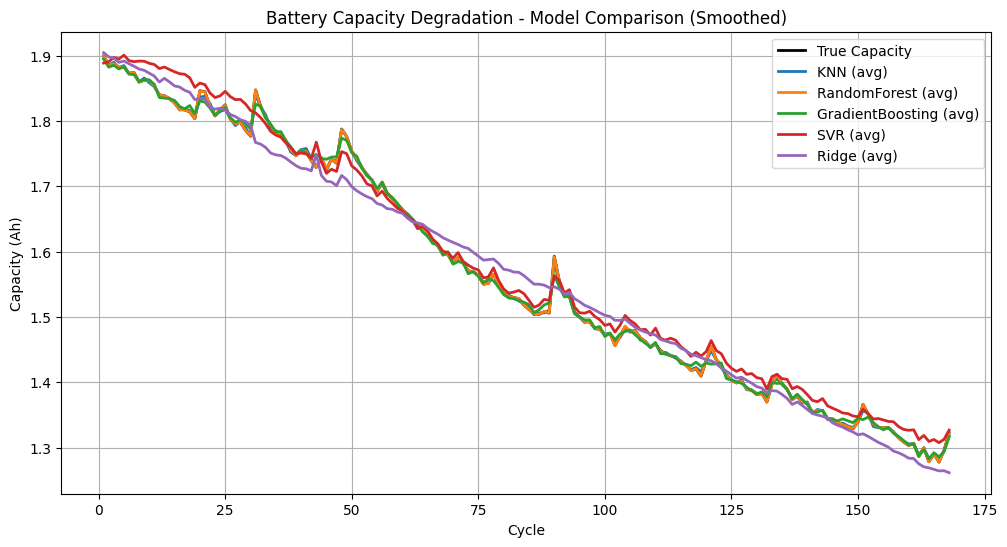

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the true capacity degradation curve (averaged by cycle)
true_curve = pd.DataFrame({"cycle": X_test["cycle"], "capacity": y_test})
true_mean = true_curve.groupby("cycle")["capacity"].mean()
plt.plot(true_mean.index, true_mean.values, "k-", label="True Capacity", linewidth=2)

# Plot smooth averaged predictions for each model
for name, res in results.items():
    cycle_pred = pd.DataFrame({
        "cycle": X_test["cycle"],
        "y_pred": res["y_pred"]
    })
    mean_pred = cycle_pred.groupby("cycle")["y_pred"].mean()
    plt.plot(mean_pred.index, mean_pred.values, label=f"{name} (avg)", linewidth=2)

plt.xlabel("Cycle")
plt.ylabel("Capacity (Ah)")
plt.title("Battery Capacity Degradation - Model Comparison (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# -------------------------------
# 8. Check Overfitting (Train vs Test)
# -------------------------------
for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    overfit_rmse = rmse_test - rmse_train
    overfit_r2 = r2_train - r2_test

    results[name].update({
        "RMSE_train": rmse_train,
        "RMSE_test": rmse_test,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "Overfit_RMSE": overfit_rmse,
        "Overfit_R2": overfit_r2
    })

    print(f"{name} -> Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}, "
          f"Overfit RMSE: {overfit_rmse:.4f}, Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}, "
          f"Overfit R2: {overfit_r2:.4f}")


NameError: name 'models' is not defined

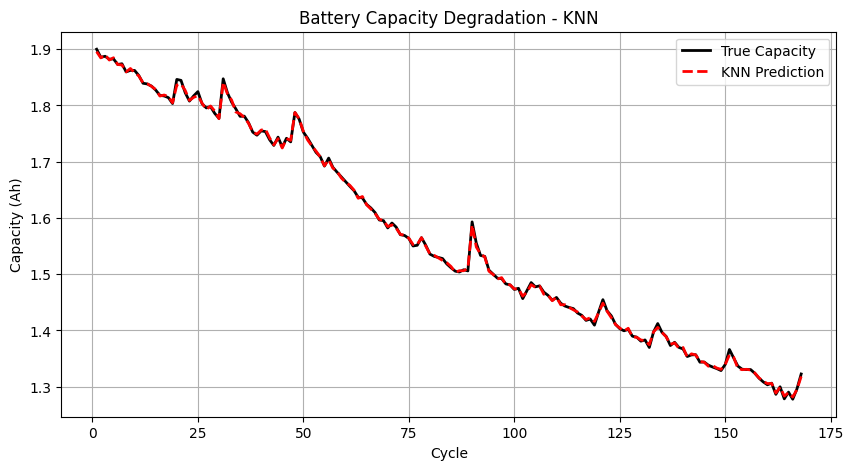

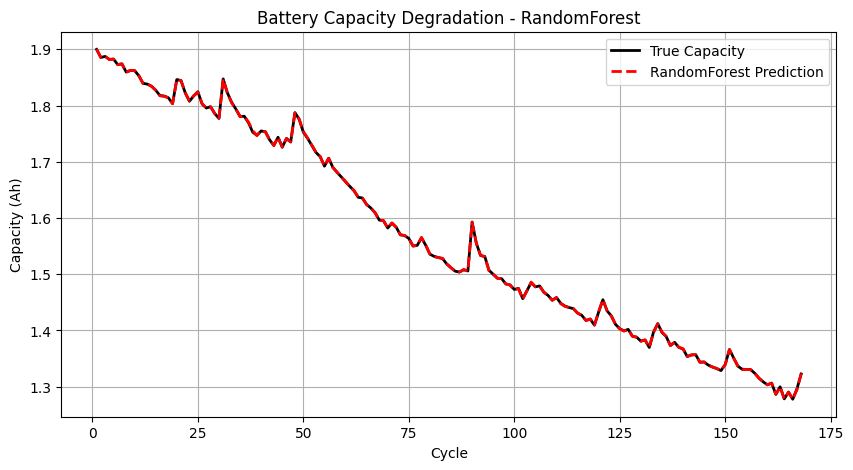

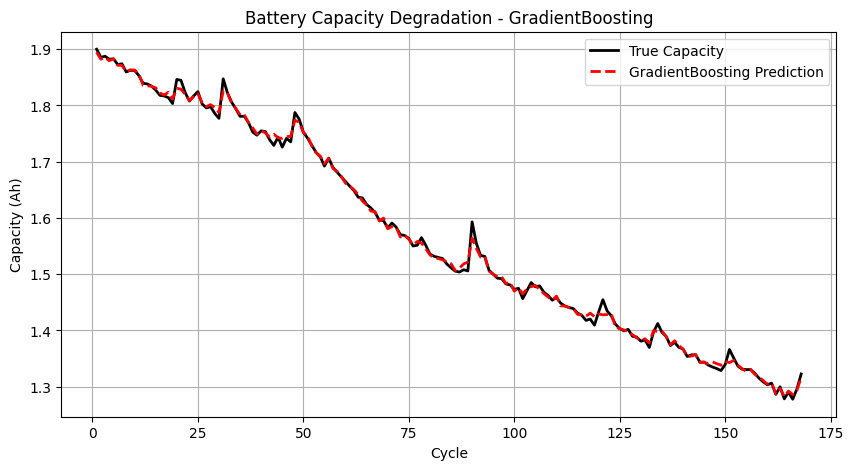

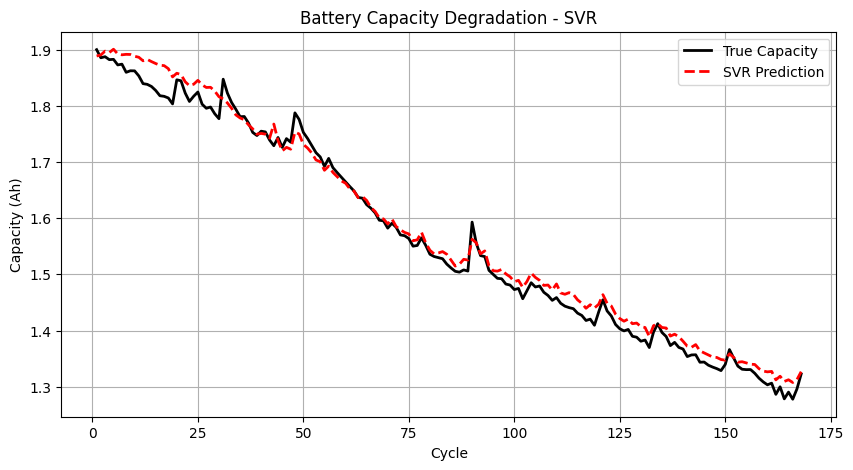

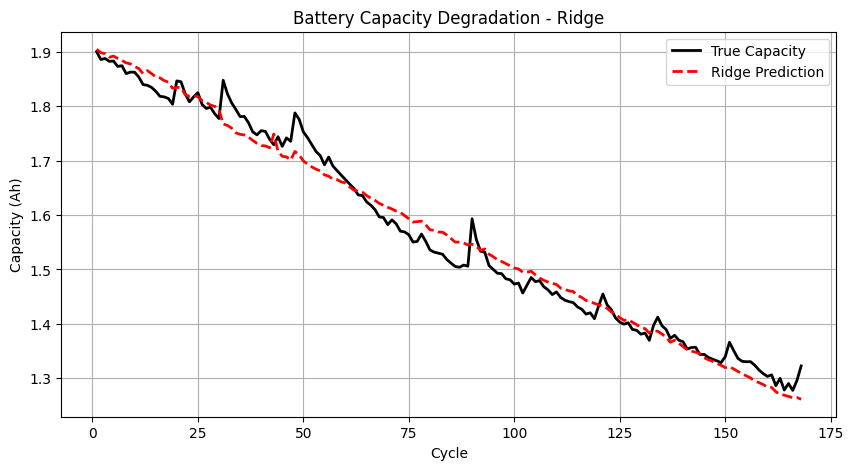

In [ ]:
import matplotlib.pyplot as plt

# True capacity averaged by cycle
true_curve = pd.DataFrame({"cycle": X_test["cycle"], "capacity": y_test})
true_mean = true_curve.groupby("cycle")["capacity"].mean()

# Plot each model in a separate figure
for name, res in results.items():
    plt.figure(figsize=(10, 5))

    # Model prediction averaged by cycle
    cycle_pred = pd.DataFrame({"cycle": X_test["cycle"], "y_pred": res["y_pred"]})
    mean_pred = cycle_pred.groupby("cycle")["y_pred"].mean()

    # Plot true capacity
    plt.plot(true_mean.index, true_mean.values, "k-", label="True Capacity", linewidth=2)

    # Plot model prediction
    plt.plot(mean_pred.index, mean_pred.values, "r--", label=f"{name} Prediction", linewidth=2)

    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.title(f"Battery Capacity Degradation - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
for name, model in models.items():
    # Predictions on training set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    results[name] = {
        "RMSE_train": rmse_train,
        "RMSE_test": rmse_test,
        "R2_train": r2_train,
        "R2_test": r2_test,
        "y_pred": y_test_pred
    }

    print(f"{name} -> Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test:.4f}, "
          f"Train R2: {r2_train:.4f}, Test R2: {r2_test:.4f}")


KNN -> Train RMSE: 0.0073, Test RMSE: 0.0099, Train R2: 0.9985, Test R2: 0.9973
RandomForest -> Train RMSE: 0.0022, Test RMSE: 0.0058, Train R2: 0.9999, Test R2: 0.9991
GradientBoosting -> Train RMSE: 0.0187, Test RMSE: 0.0189, Train R2: 0.9904, Test R2: 0.9902
SVR -> Train RMSE: 0.0457, Test RMSE: 0.0458, Train R2: 0.9426, Test R2: 0.9424
Ridge -> Train RMSE: 0.0671, Test RMSE: 0.0670, Train R2: 0.8762, Test R2: 0.8766


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


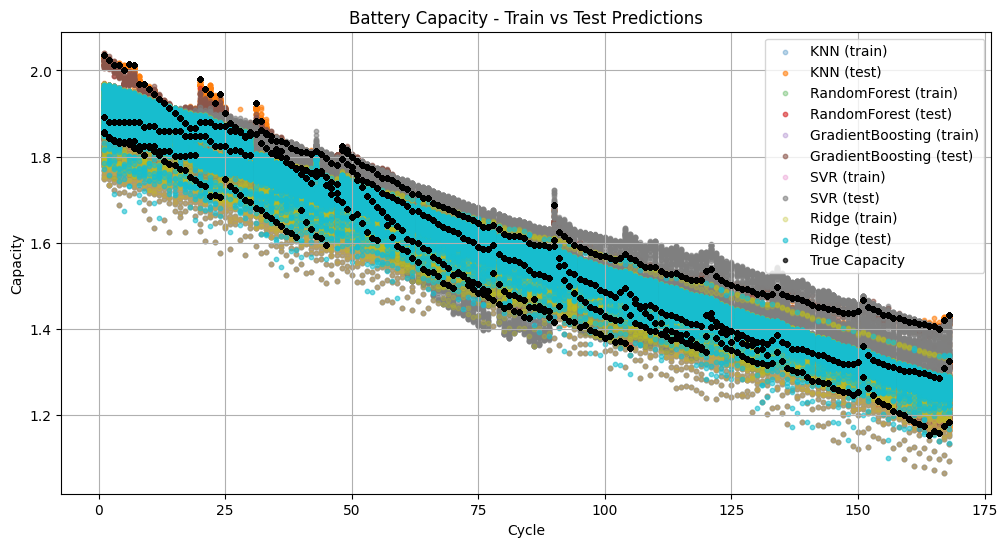

In [ ]:
plt.figure(figsize=(12,6))

for name, res in results.items():
    plt.scatter(X_train["cycle"], model.predict(X_train), label=f"{name} (train)", alpha=0.3, s=10)
    plt.scatter(X_test["cycle"], res["y_pred"], label=f"{name} (test)", alpha=0.6, s=10)

plt.plot(X_test["cycle"], y_test, "k.", label="True Capacity", alpha=0.7)
plt.xlabel("Cycle")
plt.ylabel("Capacity")
plt.title("Battery Capacity - Train vs Test Predictions")
plt.legend()
plt.grid(True)
plt.show()


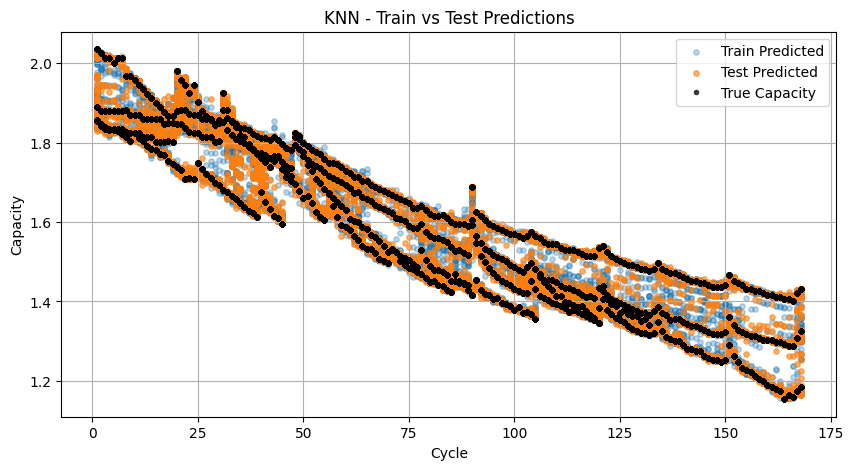

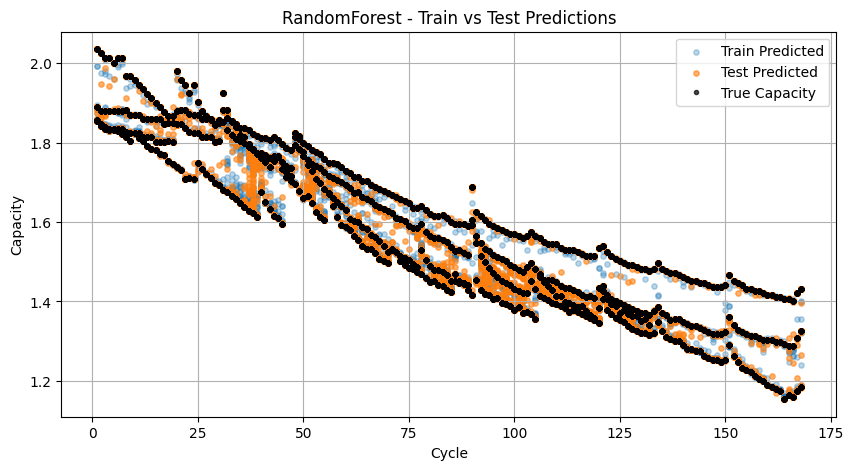

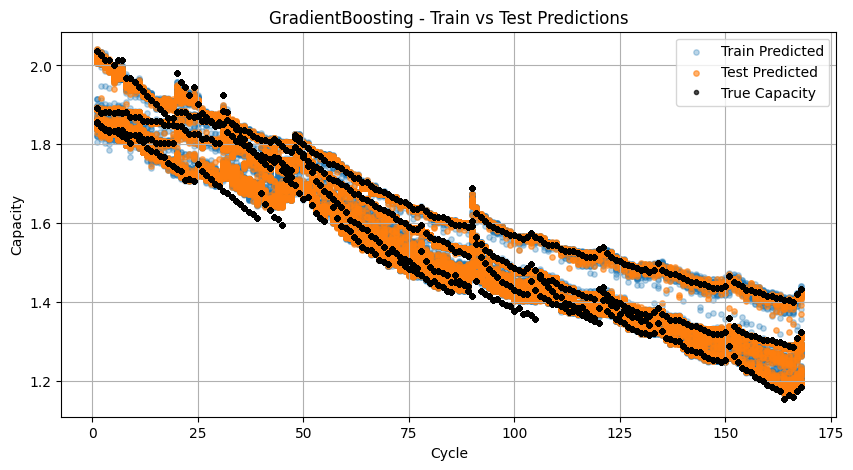

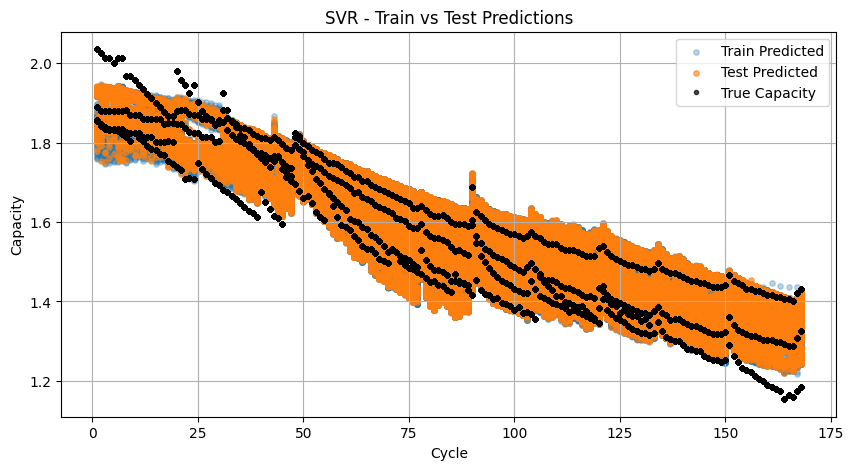

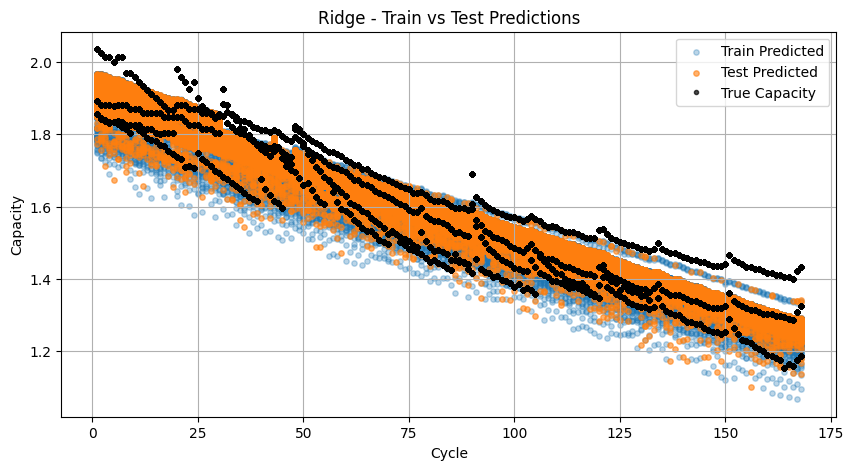

In [ ]:
# -------------------------------
# 1. Individual Train vs Test Plots
# -------------------------------
for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    plt.figure(figsize=(10,5))

    # Plot train predictions
    plt.scatter(X_train["cycle"], y_train_pred, label="Train Predicted", alpha=0.3, s=15)
    # Plot test predictions
    plt.scatter(X_test["cycle"], y_test_pred, label="Test Predicted", alpha=0.6, s=15)
    # Plot true capacity (test)
    plt.plot(X_test["cycle"], y_test, "k.", label="True Capacity", alpha=0.7)

    plt.xlabel("Cycle")
    plt.ylabel("Capacity")
    plt.title(f"{name} - Train vs Test Predictions")
    plt.legend()
    plt.grid(True)
    plt.show()
